# Installation des packages

# Préparation des données

In [1]:
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv
import pandas as pd

landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# Codes ISO-2 et ISO-3 relatifs aux pays

In [2]:
codesISO_data = dc.get_ISOcodes(codesISO_url)
codesISO_data = dcl.clean_ISOData(codesISO_data)
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


# PIB Réel

L'API permet de récupérer des données sur les pays via leurs codes ISO avec 2 lettres
Exemple : "FR" pour la France, "DE" pour l'Allemagne, "GB" pour le Royaume-Uni, etc.

In [3]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = wb.get_indicator("PIB_reel", liste_pays, start=1990, end=2024)

PIB_Reel_data

,country,date,PIB
0,Afghanistan,2024,NaN
1,Afghanistan,2023,1.567265e+10
2,Afghanistan,2022,1.532523e+10
3,Afghanistan,2021,1.634520e+10
4,Afghanistan,2020,2.062196e+10
...,...,...,...
6750,Zimbabwe,1994,1.775729e+10
6751,Zimbabwe,1993,1.625602e+10
6752,Zimbabwe,1992,1.608687e+10
6753,Zimbabwe,1991,1.768090e+10


Il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe PIB_reel_data
# Faire correspondre les noms des pays à la liste des ISO

In [4]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

matching_dictionnary = {}

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries 
potential_matching_complicated_word_countries = PIB_countries 

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[pib_country] = iso_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

# Résoudre les derniers problèmes

for pib_country in unresolved_potential_matching_countries:
    for iso_country in unresolved_ISO_countries:
        # Je n'ai pas besoin des caractères après la virgule pour les pays problématiques.
        pib_country = pib_country.split(',')[0]
        
        if pib_country[:5] == iso_country[:5]:
            matching_dictionnary[pib_country] = iso_country
            break
        
# Résoudre les problèmes d'autres pays déviants manuellement
          
matching_dictionnary['Congo, Dem. Rep.'] = 'Congo (the Democratic Republic of the)'
matching_dictionnary['Congo, Rep.'] = 'Congo (the)[k]'
matching_dictionnary['Turkiye'] = 'Türkiye[ag]'
matching_dictionnary['Korea, Rep.'] = 'Korea (the Republic of)[u]'
matching_dictionnary['Korea, Dem. People\'s Rep.'] = 'Korea (the Democratic People\'s Republic of)[t]'
matching_dictionnary['Venezuela, RB'] = 'Venezuela (Bolivarian Republic of)'

In [5]:
# Matcher maintenant les pays aux ISO

ISO_matching_dictionnary = {}
for i in range(len(codesISO_data)):
    line = codesISO_data.iloc[i]
    ISO_matching_dictionnary[line["Pays"]] = line["ISO-3"]
    
ISO_matching_dictionnary

for key in matching_dictionnary.keys():
    matching_dictionnary[key] = ISO_matching_dictionnary[matching_dictionnary[key]]
    
matching_dictionnary

{'Kuwait': 'KWT',
 'Georgia': 'GEO',
 'Uzbekistan': 'UZB',
 'Azerbaijan': 'AZE',
 'Bahrain': 'BHR',
 'Estonia': 'EST',
 'Norway': 'NOR',
 'Saudi Arabia': 'SAU',
 'Indonesia': 'IDN',
 'Brunei Darussalam': 'BRN',
 'Niger': 'NGA',
 'Kiribati': 'KIR',
 'India': 'IND',
 'Afghanistan': 'AFG',
 'Chile': 'CHL',
 'Yemen, Rep.': 'YEM',
 'United Arab Emirates': 'ARE',
 'Bhutan': 'BTN',
 'Australia': 'AUS',
 'Guatemala': 'GTM',
 'Solomon Islands': 'SLB',
 'Botswana': 'BWA',
 'Denmark': 'DNK',
 'Serbia': 'SRB',
 'San Marino': 'SMR',
 'Sierra Leone': 'SLE',
 'Guinea-Bissau': 'GIN',
 'Guinea': 'GNQ',
 'Cyprus': 'CYP',
 'Honduras': 'HND',
 'Barbados': 'BRB',
 'Chad': 'TCD',
 'Burkina Faso': 'BFA',
 'Japan': 'JPN',
 'Timor-Leste': 'TLS',
 'Armenia': 'ARM',
 'Panama': 'PAN',
 'Djibouti': 'DJI',
 'Namibia': 'NAM',
 'Russian Federation': 'RUS',
 'Ethiopia': 'ETH',
 'Cuba': 'CUB',
 'Senegal': 'SEN',
 'Greece': 'GRC',
 'Belgium': 'BEL',
 'South Africa': 'ZAF',
 'Mongolia': 'MNG',
 'Mauritania': 'MRT',
 'Lib

In [6]:
PIB_Reel_data["country"] = PIB_Reel_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
PIB_Reel_data


,country,date,PIB
0,AFG,2024,NaN
1,AFG,2023,1.567265e+10
2,AFG,2022,1.532523e+10
3,AFG,2021,1.634520e+10
4,AFG,2020,2.062196e+10
...,...,...,...
6750,ZWE,1994,1.775729e+10
6751,ZWE,1993,1.625602e+10
6752,ZWE,1992,1.608687e+10
6753,ZWE,1991,1.768090e+10


# Valeurs manquantes

In [7]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 187 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.


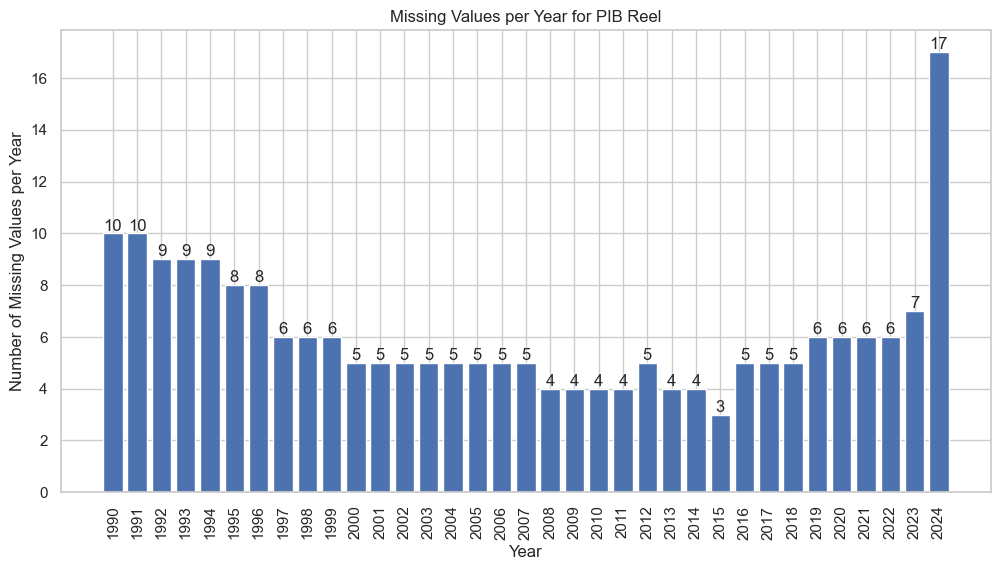

In [8]:
# Là on va checker d'où viennent les valeurs manquantes

# On va d'abord faire une analyse par date pour voir si c'est ça qui cause le problème

dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

In [9]:
# C'est bizarre qu'en 2024 il y ait plus de valeurs manquantes en 2024. Vérifions les pays dont les valeurs sont manquantes en 2024
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,AFG,2024,NaN
910,BTN,2024,NaN
1435,CUB,2024,NaN
1820,ERI,2024,NaN
3255,KOR,2024,NaN
3360,LBN,2024,NaN
3500,LIE,2024,NaN
3745,MCO,2024,NaN
4830,PLW,2024,NaN
4935,PRK,2024,NaN


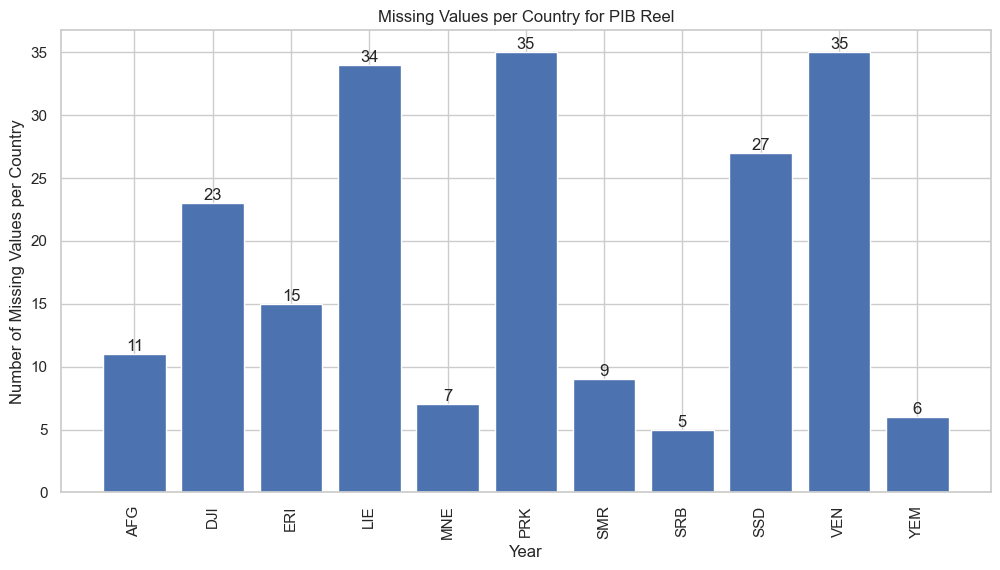

In [10]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

In [11]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)
da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 187 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 176 pays de 1990 à 2024.
Il y a 9 valeurs manquantes sur un total de 6335 dans la base de données. Soit un ratio de 0.14% de valeurs manquantes dans la base de données.


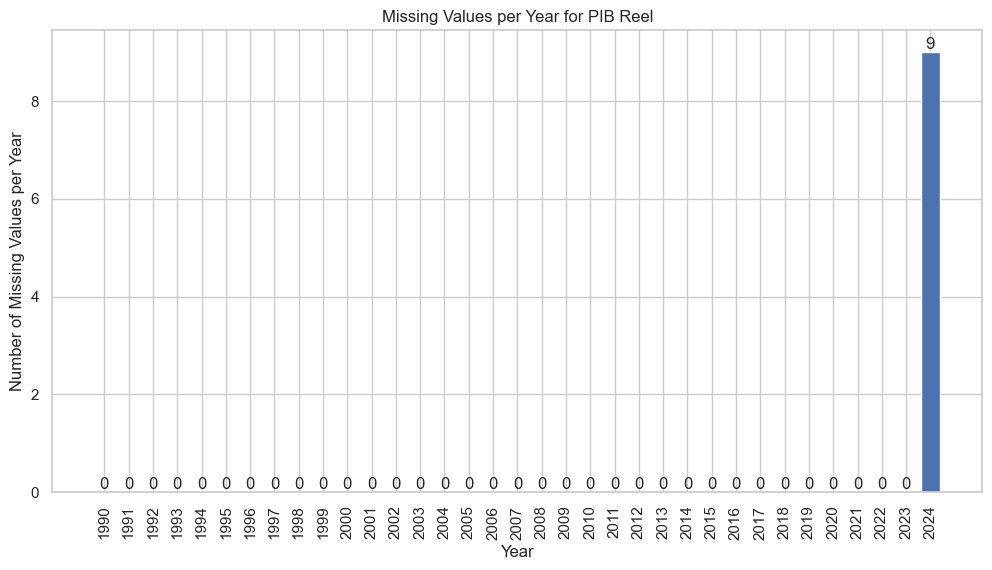

In [12]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

In [13]:
# La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")
PIB_Reel_data_final

Le dataframe contient des données temporelles relatives à 176 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6335 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


,country,date,PIB
0,AGO,2024,8.959422e+10
1,AGO,2023,8.579857e+10
2,AGO,2022,8.488345e+10
3,AGO,2021,8.237534e+10
4,AGO,2020,8.139919e+10
...,...,...,...
6330,ZWE,1994,1.775729e+10
6331,ZWE,1993,1.625602e+10
6332,ZWE,1992,1.608687e+10
6333,ZWE,1991,1.768090e+10


## Description du PIB

## Evolution du PIB mondial

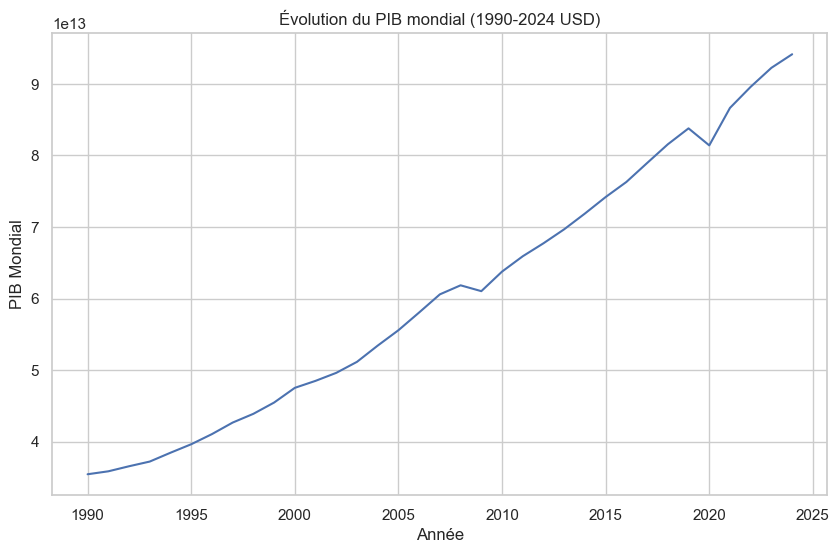

In [14]:
## Description du PIB
import matplotlib.pyplot as plt
dv.plot_world_PIB(PIB_Reel_data_final)

# Faire un commentaire

# Analyse des PIB de pays par quartiles 

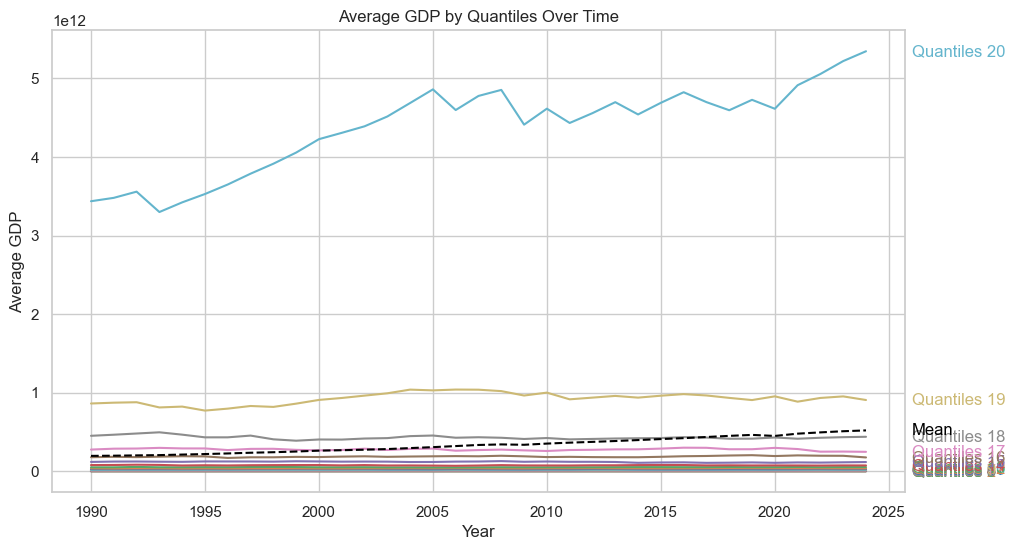

In [15]:
dv.plot_PIB_quantile(PIB_Reel_data_final)


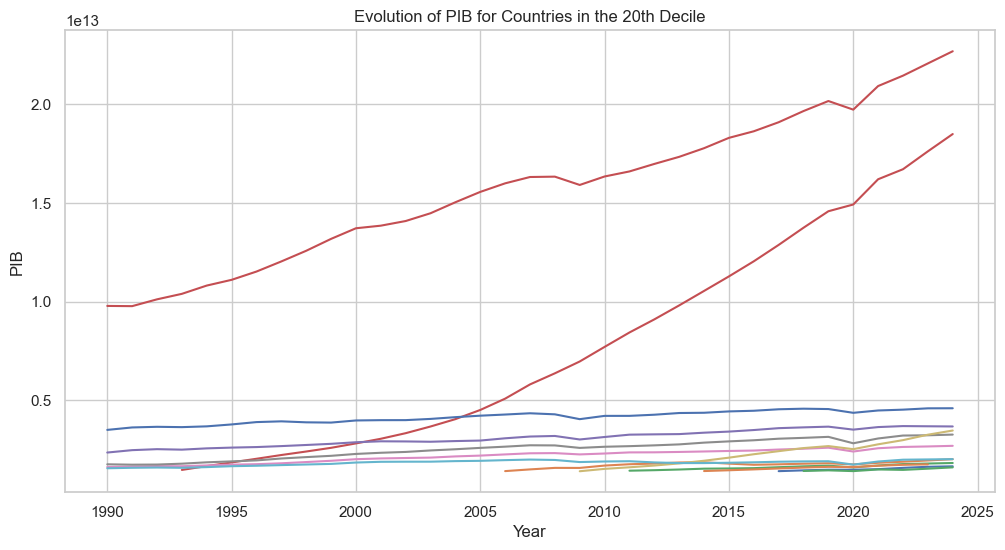

Countries in the 20th-decile: ['AUS' 'BRA' 'CAN' 'CHN' 'DEU' 'ESP' 'FRA' 'GBR' 'IND' 'ITA' 'JPN' 'KOR'
 'RUS' 'USA']


In [16]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

Faire un commentaire sur le fait que ce soient les pays les plus développés qui apparaissent dans ce graphique

# Ajout de la variable symbolisant la taille du pays dans l'économie mondiale

In [17]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)

,country,avgWeightCountry
168,USA,26.428834
31,CHN,10.550152
79,JPN,7.350154
43,DEU,5.380310
56,GBR,4.710886
...,...,...
142,STP,0.000335
102,MHL,0.000311
84,KIR,0.000272
120,NRU,0.000156


# Clustering

On sépare en 4 clusters. Très Bas, Bas, Haut, Très Haut. On fait tourner les kmeans et on remarque les USA sont en tête suivi par la Chine. Ce qui correspond bien à la réalité. Faire d'autre commentaires ensuite.

In [18]:
dv.visualize_economicPower_clusters(weightCountry)


# Temps de reprise des pays après une crise

In [19]:
import pandas as pd
import numpy as np

def peak_to_breach_times(df_country):

    # Ordonner le dataframe pour que les séries temporelles commncent avec des dates croissantes
    df = df_country.sort_values('date').reset_index(drop=True).copy()
    
    df['prev_pib'] = df['PIB'].shift(1)
    df['next_pib'] = df['PIB'].shift(-1)
    df['is_peak'] = (df['PIB'] > df['prev_pib']) & (df['PIB'] > df['next_pib']) # Identifier les pics locaux i.e les années où le PIB est plus élevé que l'année précédente et l'année suivante
    
    peak_indices = df.index[df['is_peak']].tolist()
    
    times = []
    
    for i in peak_indices:
        peak_year = df.loc[i, 'date']
        peak_val = df.loc[i, 'PIB']
        
        # données survenues après le pic
        after_thePeak = df.loc[i+1:].copy()
        if after_thePeak.empty:
            continue
        
        # Si aucune valeur dans la suite n'est inférieure au pic, on continue parce que ça veut dire qu'il n'y a pas eu de crise après ce pic 
        if not (after_thePeak['PIB'] < peak_val).any():

            continue
        
        # Sinon on cherche la première année où le PIB dépasse le pic pour signaler un retour à la normale
        breached = after_thePeak[after_thePeak['PIB'] > peak_val]
        if breached.empty:
            continue
        
        breach_year = breached['date'].iloc[0]
        time_to_breach = breach_year - peak_year
        times.append(time_to_breach)
    
    mean_time = np.mean(times) if len(times) > 0 else np.nan # Permet de calculer un cas moyen
    return mean_time


responseTime_data = pd.DataFrame(PIB_Reel_data_final.groupby('country')[['date','PIB']].apply(lambda x:peak_to_breach_times(x)))
responseTime_data.rename(columns={0:"avgResponseTime"},inplace=True)
responseTime_data.reset_index(inplace=True)
responseTime_data

,country,avgResponseTime
0,AGO,6.000000
1,ALB,2.500000
2,AND,7.333333
3,ARE,3.000000
4,ARG,2.833333
...,...,...
171,VUT,4.000000
172,WSM,3.000000
173,ZAF,2.500000
174,ZMB,2.666667


# Checker des valeurs manquantes

In [20]:
da.check_missing_values(responseTime_data,"avgResponseTime")

Il y a 17 valeurs manquantes sur un total de 176 dans la base de données. Soit un ratio de 9.66% de valeurs manquantes dans la base de données.


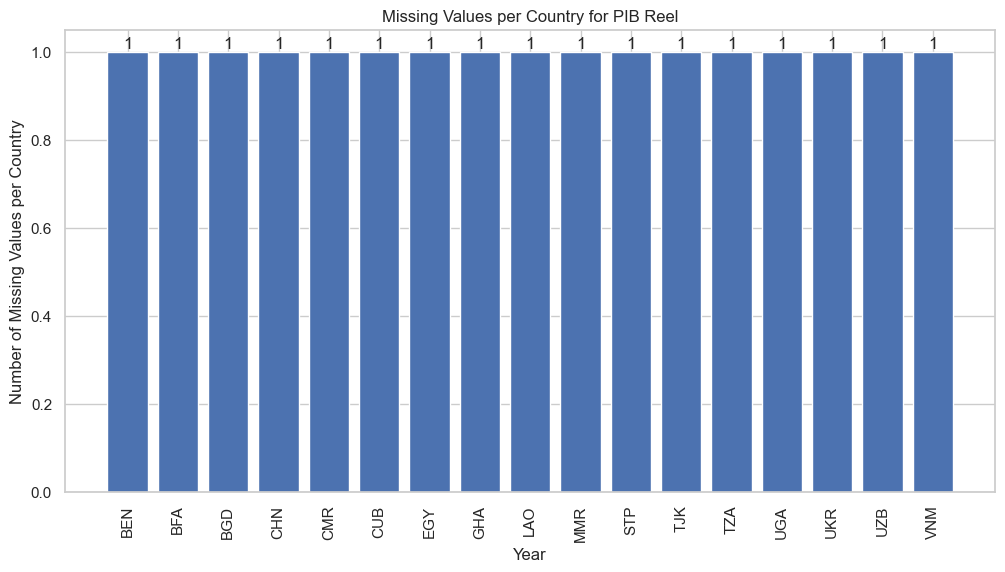

Index(['BEN', 'BFA', 'BGD', 'CHN', 'CMR', 'CUB', 'EGY', 'GHA', 'LAO', 'MMR',
       'STP', 'TJK', 'TZA', 'UGA', 'UKR', 'UZB', 'VNM'],
      dtype='object', name='country')

In [23]:
dv.plot_missing_values_per_country(responseTime_data,"avgResponseTime",treshold=0)

Certains des pays n'ont 